# TODO

- general improvements
 

# Prepare Data

In [ ]:
#Import Google Drive to load the WGAN dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#remove existing dir, if any
!rm -rf /content/Dataset_WGAN

#Make new dirs
!mkdir /content/Dataset_WGAN
!mkdir /content/Dataset_WGAN/masks
!mkdir /content/Dataset_WGAN/images

#load and (quietly) extract the train files from Drive
!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/train_set.zip -d /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/mean300.mat /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/*.txt /content/Dataset_WGAN/

"""!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/train_set.zip -d /content/Dataset_WGAN/
!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/test_set.zip -d /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/*.txt /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/mean300.mat /content/Dataset_WGAN/
!cp /content/drive/MyDrive/Colab\ Notebooks/weather_git/TensorflowUtils.py /content
!mkdir /content/Dataset_WGAN/tfrecords"""

#!ls /content/Dataset_WGAN/

'!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/train_set.zip -d /content/Dataset_WGAN/\n!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/test_set.zip -d /content/Dataset_WGAN/\n!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/*.txt /content/Dataset_WGAN/\n!cp /content/drive/MyDrive/Diplomityo/Dataset_WGAN/mean300.mat /content/Dataset_WGAN/\n!cp /content/drive/MyDrive/Colab\\ Notebooks/weather_git/TensorflowUtils.py /content\n!mkdir /content/Dataset_WGAN/tfrecords'

In [ ]:
"""Import libraries"""

#(quietly) install tensorflow examples to use pi2pix network model
!pip install -q git+https://github.com/tensorflow/examples.git

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import matplotlib
import os
import pathlib
import time
import datetime
import glob
import tensorflow as tf
import cv2

from PIL import Image
from scipy import misc
from tensorflow import keras
from keras import layers
from IPython import display
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

tf.__version__
#Check if it runs on GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

""" Path and filenames """
root_path = "/content/Dataset_WGAN/"
dir_img = "/content/Dataset_WGAN/train_images/"
dir_mat = "/content/Dataset_WGAN/train_mats/"
image_save_dir = "/content/Dataset_WGAN/images/image"
mask_save_dir = "/content/Dataset_WGAN/masks"
seg_model_vgg16_save_dir = "/content/drive/MyDrive/Diplomityo/Models/seg_model_vgg16"
seg_model_vgg19_save_dir = "/content/drive/MyDrive/Diplomityo/Models/seg_model_vgg19"
seg_model_dense121_save_dir = "/content/drive/MyDrive/Diplomityo/Models/seg_model_dense121"
seg_model_dense169_save_dir = "/content/drive/MyDrive/Diplomityo/Models/seg_model_dense169"
seg_model_dense201_save_dir = "/content/drive/MyDrive/Diplomityo/Models/seg_model_dense201"
gen_sunny_to_cloudy_model_save_dir = "/content/drive/MyDrive/Diplomityo/Models/gen_sunny_to_cloudy_model"
gen_cloudy_to_sunny_model_save_dir = "/content/drive/MyDrive/Diplomityo/Models/gen_cloudy_to_sunny_model"
disc_cloudy_to_sunny_model_save_dir = "/content/drive/MyDrive/Diplomityo/Models/disc_cloudy_to_sunny_model"
disc_sunny_to_cloudy_model_save_dir = "/content/drive/MyDrive/Diplomityo/Models/disc_sunny_to_cloudy_model"
att_model_save_dir = "/content/drive/MyDrive/Diplomityo/Models/att_model"
txtfile = root_path + 'train.txt'

ORIGINAL_HEIGHT = 300
ORIGINAL_WIDTH = 300

meanfile = sio.loadmat(root_path + 'mean300.mat')
meanvalue = meanfile['mean'] #mean value of images in training set

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Num GPUs Available:  0


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 15 15:21:45 2017', '__version__': '1.0', '__globals__': [], 'seg_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}
<class 'numpy.ndarray'>
(300, 300)
0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


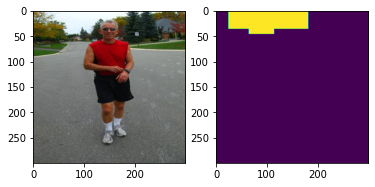

In [ ]:
"""Test the files by visualizing one image and mask"""

dir_img = "/content/Dataset_WGAN/train_images"
dir_mat = "/content/Dataset_WGAN/train_mats"

img = plt.imread(dir_img + "/cloudy_0004.jpg")
mask = sio.loadmat(dir_mat + "/cloudy_mask_0004.mat")

print(mask)

mask = mask["seg_mask"]

print(type(mask))
print(mask.shape)
print(mask[0][0])
print(mask)

#img_raw = img.tobytes()
#mask_raw = mask.tobytes()

#mask1 = np.fromstring(mask_raw, dtype=np.float64)
example_img = img.reshape((ORIGINAL_HEIGHT, ORIGINAL_WIDTH, -1))
example_img = example_img #+ meanvalue
example_mask = mask.reshape((ORIGINAL_HEIGHT, ORIGINAL_WIDTH))

plt.subplot(1,2,1)
plt.imshow(np.uint8(example_img))
plt.subplot(1,2,2)
plt.imshow(np.uint8(example_mask))

In [ ]:
images = []
masks = []

dir_img = "/content/Dataset_WGAN/train_images/"
dir_mat = "/content/Dataset_WGAN/train_mats/"
#!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/train_set.zip -d /content/Dataset_WGAN/

image_index = 0

"""read lines in the filenames .txt 
The format is "imageXXXX.jpg maskXXXX.mat category"
"""

reader = open(txtfile)
for i in reader.readlines():
    if image_index < 2001:
      item = i.split()

      img = cv2.imread(dir_img + item[0])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      images.append(tf.convert_to_tensor(img)) 

      maskmat = sio.loadmat(dir_mat + item[1])
      mask = tf.convert_to_tensor(maskmat["seg_mask"])
      masks.append(mask)   

    image_index += 1

reader.close()

<class 'list'>
2001
<class 'list'>
2001


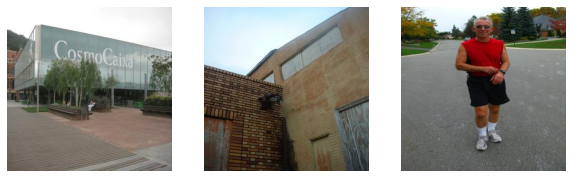

In [ ]:
print(type(masks))
print(len(masks))

print(type(images))
print(len(images))

plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap="jet")
    plt.axis("off")
plt.show()

In [ ]:
print(images[0].numpy().min(), images[0].numpy().max())
#masks[0].numpy().min(), masks[0].numpy().max()

0 255


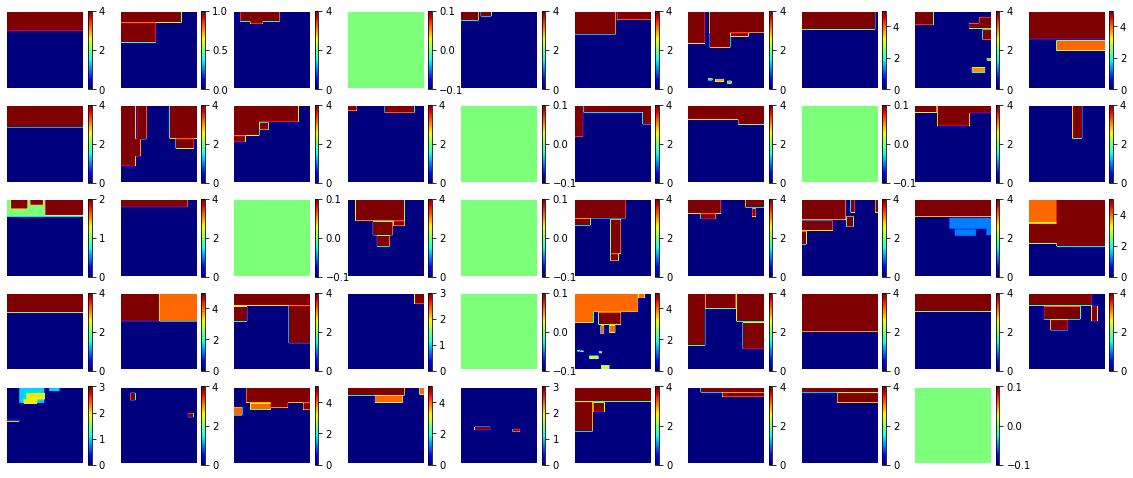

In [ ]:
plt.figure(figsize=(20,17))
for i in range(1,50):
    plt.subplot(10,10,i)
    img = masks[i]
    plt.imshow(img, cmap="jet")
    plt.colorbar()
    plt.axis("off")
plt.show()

# Generator model (CycleGAN)

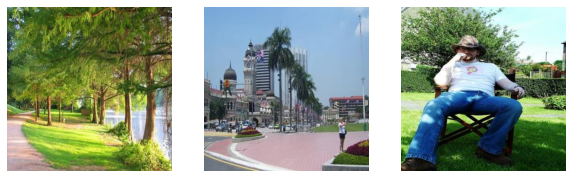

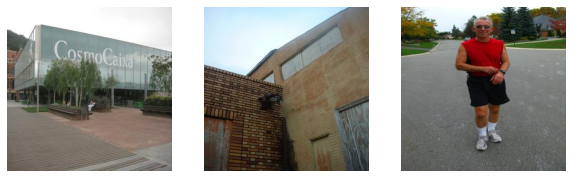

In [ ]:
"""Make a dataset of cloudy - sunny categories"""

sunny_images = []
cloudy_images = []

image_index = 0

reader = open(txtfile)
for i in reader.readlines():
    """    if image_index > 999:
      break"""
    item = i.split()

    img = cv2.imread(dir_img + item[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if "sunny" in item[0]:
      sunny_images.append(tf.convert_to_tensor(img))

    else:
      cloudy_images.append(tf.convert_to_tensor(img))

    image_index = image_index + 1

reader.close()

plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = sunny_images[i]
    plt.imshow(img, cmap="jet")
    #plt.colorbar()
    plt.axis("off")
plt.show()

plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = cloudy_images[i]
    plt.imshow(img, cmap="jet")
    #plt.colorbar()
    plt.axis("off")
plt.show()

sunny_images = np.array(sunny_images)
cloudy_images = np.array(cloudy_images)

4000
4000


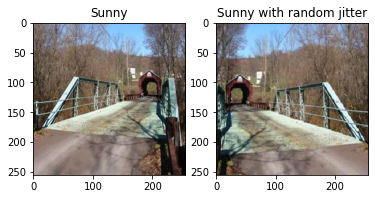

In [ ]:
print(len(sunny_images))
print(len(cloudy_images))

AT= tf.data.AUTOTUNE

BUFFER = 100
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 10


def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def resize(image):
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image

def random_jitter(image):
  image = tf.image.resize(image, [300, 300],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  image = resize(image)
  return image

"""Create train and val sets"""

sunny_images_X, cloudy_images_X, sunny_images_y, cloudy_images_y = train_test_split(sunny_images, cloudy_images, 
                                                      test_size=0.2, 
                                                      random_state=0
                                                     )
sunny_images_X = tf.data.Dataset.from_tensor_slices(sunny_images_X)
cloudy_images_X = tf.data.Dataset.from_tensor_slices(cloudy_images_X)

sunny_images_y = tf.data.Dataset.from_tensor_slices(sunny_images_y)
cloudy_images_y = tf.data.Dataset.from_tensor_slices(cloudy_images_y)

train_sunny = sunny_images_X.cache().map(
    preprocess_image_train, num_parallel_calls=AT).shuffle(
    BUFFER).batch(BATCH_SIZE)

train_cloudy = cloudy_images_y.cache().map(
    preprocess_image_train, num_parallel_calls=AT).shuffle(
    BUFFER).batch(BATCH_SIZE)

val_sunny = sunny_images_y.map(
    preprocess_image_test, num_parallel_calls=AT).cache().shuffle(
    BUFFER).batch(BATCH_SIZE)

val_cloudy = cloudy_images_y.map(
    preprocess_image_test, num_parallel_calls=AT).cache().shuffle(
    BUFFER).batch(BATCH_SIZE)

sample_sunny = next(iter(train_sunny))
sample_cloudy = next(iter(train_cloudy))

plt.subplot(121)
plt.title("Sunny")
plt.imshow(sample_sunny[0] * 0.5 + 0.5)

## Pure CycleGAN

(8, 256, 256, 3)
(8, 256, 256, 3)


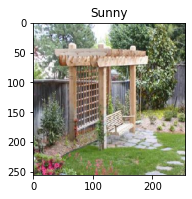

In [ ]:
test_cloudy = next(iter(val_cloudy))
plt.subplot(121)
plt.title("Sunny")
plt.imshow(test_cloudy[0] * 0.5 + 0.5)

print(sample_cloudy.shape)
print(test_cloudy.shape)

In [ ]:
"""Use the CycleGAN style pix2pix GAN model"""
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target=False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target=False)

to_sunny = generator_g(sample_sunny)
to_cloudy = generator_f(sample_cloudy)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_sunny, to_sunny, sample_cloudy, to_cloudy]
title = ["Sunny", "To Cloudy", "Cloudy", "To Sunny"]

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def perceptual_loss():
  perceptual_loss = 1

  return perceptual_loss

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ("Latest checkpoint restored!")

In [ ]:
EPOCHS = 20

def generate_images(model, input_img, prediction_text="Predicted Image"):
  prediction = model(input_img)
    
  plt.figure(figsize=(12, 12))

  display_list = [input_img[0], prediction[0]]
  title = ["Input Image", prediction_text]

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])

    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis("off")
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

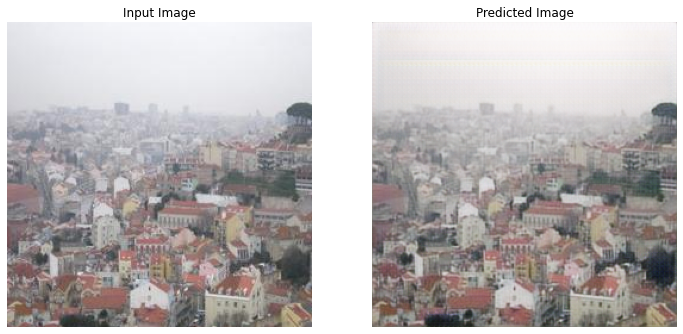

Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Time taken for epoch 15 is 149.41853618621826 sec



KeyboardInterrupt: ignored

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  #n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_sunny, train_cloudy)):
    train_step(image_x, image_y)
    """if n % 10 == 0:
      #print (".", end="")
    n += 1"""

  clear_output(wait=True)

  generate_images(generator_g, sample_cloudy)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ("Saving checkpoint for epoch {} at {}".format(epoch+1,
                                                         ckpt_save_path))

  print ("Time taken for epoch {} is {} sec\n".format(epoch + 1,
                                                      time.time()-start))

In [ ]:
#keras.utils.plot_model(generator_g, show_shapes=True)
#keras.models.save_model(model=generator_g, filepath=gen_sunny_to_cloudy_model_save_dir)
#keras.models.save_model(model=generator_f, filepath=gen_cloudy_to_sunny_model_save_dir)
#generator_g = keras.models.load_model(filepath=gen_model_save_dir)

keras.models.save_model(model=discriminator_x, filepath=disc_sunny_to_cloudy_model_save_dir)
keras.models.save_model(model=discriminator_y, filepath=disc_cloudy_to_sunny_model_save_dir)

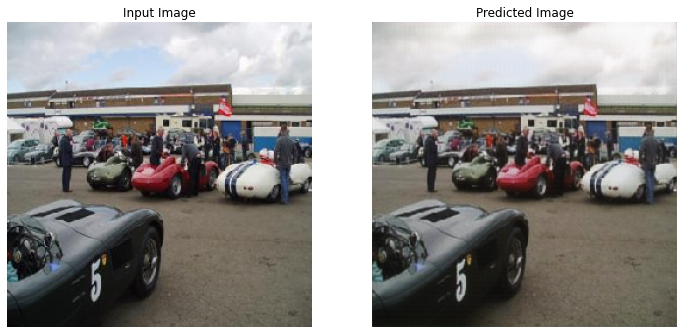

In [ ]:
#test_cloudy = test_cloudy.reshape(-1, 256, 256, 3)

#test_sunny = next(iter(val_sunny))

#for inp in test_cloudy:
generate_images(generator_g, test_sunny)

In [ ]:
# Run the trained model on the test dataset

inp = next(iter(val_cloudy))

prediction = generator_g(inp)
    
plt.figure(figsize=(12, 12))

#display_list = [input_img[0], prediction[0]]
title = ["Input Image", "Predicted image"]

for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])

  plt.imshow(prediction * 0.5 + 0.5)
  plt.axis("off")
plt.show()

#generate_images(generator_g, inp)

# Segmentation (VGG19, VGG16, DenseNet(121, 169, 201))

Test these different models for the attention model as well (first get it working). Tell, why did you choose these models?

VGG16 to compare, if VGG19 has made an improvement in a general case...


##Common functions

In [ ]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (256,256))
    return image

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (256,256))
    mask = tf.cast(mask, tf.uint8)
    return mask 

X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]

images = []
masks = []

#X, y = [preprocess_image_mask(i, j) for i, j in zip(images, masks)]

#X = np.asarray(X[:,0], dtype=np.float32)

In [ ]:
#images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

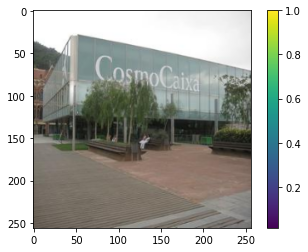

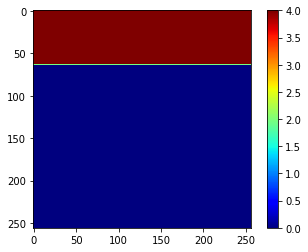

[0 4]


In [ ]:
k=1

plt.imshow(X[k])
plt.colorbar()
plt.show()

plt.imshow(y[k][:,:,0], cmap="jet")
plt.colorbar()
plt.show()

print(np.unique(y[k][:,:,0]))

k += 1

In [ ]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (256,256))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (256,256))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

def flip_horizontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vertical(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def preprocess_image_mask(img, mask):
    img = tf.cast(img, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)
    #img = resize_image(img)
    #mask = resize_mask(mask)
    img, mask = gamma(img, mask)
    img, mask = hue(img, mask)
    img, mask = brightness(img, mask)
    img, mask = crop(img, mask)
    img, mask = flip_horizontal(img, mask)
    img, mask = flip_vertical(img, mask)   
    img, mask = rotate(img, mask)

    return img, mask

In [ ]:
BATCH = 32
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

In [ ]:
train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                      test_size=0.2, 
                                                      random_state=0
                                                     )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [ ]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_horizontal)
f = train.map(flip_vertical)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

## VGG19

In [ ]:
vgg19 = keras.applications.VGG19(input_shape=[256,256,3], 
                                      include_top=False, 
                                      weights="imagenet")

40919040/80134624 [==============>...............] - ETA: 2s

KeyboardInterrupt: ignored

In [ ]:
keras.utils.plot_model(vgg19, show_shapes=True)

In [ ]:
"""Input layer
I'm using 256x256x3 instead of the original 300x300x3 of the data, since powers of two seemed to work better for UNET-model."""
input = keras.layers.Input(shape=[256,256,3])

"""Downstack names from VGG19"""
downstack_layers = ["block1_conv1", 
             "block1_pool",                
             "block2_pool", 
             "block3_pool",  
             "block4_pool",  
             "block5_pool"
             ]

"""Upstack layers from pix2pix"""
upstack_layers = [pix2pix.upsample(1024,3),
          pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3)]#,
          #pix2pix.upsample(64,3)]

"""Get the list of skip connections outputs"""
skip_outputs = [vgg19.get_layer(x).output for x in downstack_layers]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])      

"""Initialize the downstack model"""
downstack = keras.Model(inputs=vgg19.input,
                       outputs=skip_outputs)
downstack.trainable = False     

"""Create the downstack hierarchy"""
encoder = downstack(input)
layer_out = encoder[-1]
skip_connections = reversed(encoder[:-1])

"""Map the skip connections"""
for decoder, skip in zip(upstack_layers, skip_connections):
    layer_out = decoder(layer_out)
    layer_out = keras.layers.Concatenate()([layer_out, skip])
    
"""6 classed output (1-5 weather categories + 0 as none)"""
output = keras.layers.Conv2DTranspose(6, 3,
                                  strides=2,
                                  padding="same",
                                  )(layer_out)

"""Combine the connections"""
seg_model = keras.Model(inputs=input, outputs=output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='block4_pool/MaxPool:0', description="created by layer 'block4_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


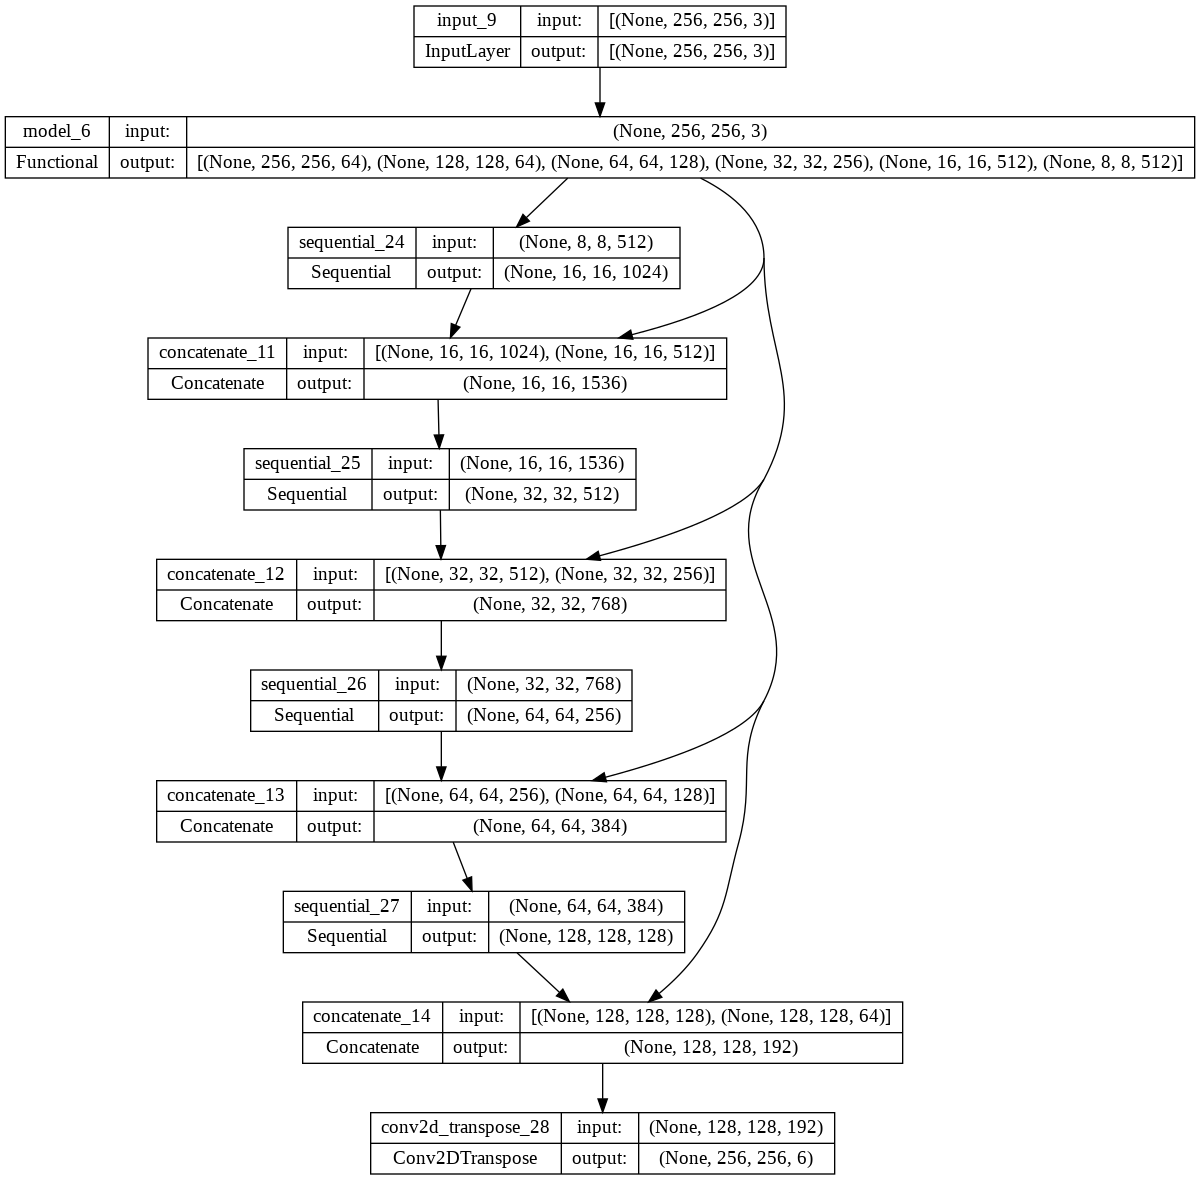

In [ ]:
keras.utils.plot_model(seg_model, show_shapes=True)

In [ ]:
"""seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=["accuracy"])"""

seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=["accuracy"])

In [ ]:
hist = seg_model.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=10)

Epoch 1/10
25/25 [==============================] - 37s 652ms/step - loss: 0.9921 - accuracy: 0.7111 - val_loss: 0.8199 - val_accuracy: 0.8006
Epoch 2/10
25/25 [==============================] - 16s 647ms/step - loss: 0.6226 - accuracy: 0.8242 - val_loss: 0.6158 - val_accuracy: 0.8385
Epoch 3/10
25/25 [==============================] - 16s 662ms/step - loss: 0.6064 - accuracy: 0.8199 - val_loss: 0.5804 - val_accuracy: 0.8429
Epoch 4/10
25/25 [==============================] - 17s 669ms/step - loss: 0.6221 - accuracy: 0.8063 - val_loss: 0.6106 - val_accuracy: 0.8338
Epoch 5/10
25/25 [==============================] - 16s 657ms/step - loss: 0.5563 - accuracy: 0.8330 - val_loss: 0.5392 - val_accuracy: 0.8424
Epoch 6/10
25/25 [==============================] - 16s 653ms/step - loss: 0.5733 - accuracy: 0.8259 - val_loss: 0.5106 - val_accuracy: 0.8543
Epoch 7/10
25/25 [==============================] - 16s 651ms/step - loss: 0.5113 - accuracy: 0.8468 - val_loss: 0.4968 - val_accuracy: 0.8566

Visualize model predictions

In [ ]:
"""Save model"""
#keras.models.save_model(model=seg_model, filepath=seg_model_vgg19_save_dir) 

"""Load model"""
#seg_model = keras.models.load_model(filepath=seg_model_save_dir)

for images, labels in val.take(1): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

1/1 [==============================] - 0s 64ms/step


<Figure size 720x288 with 0 Axes>

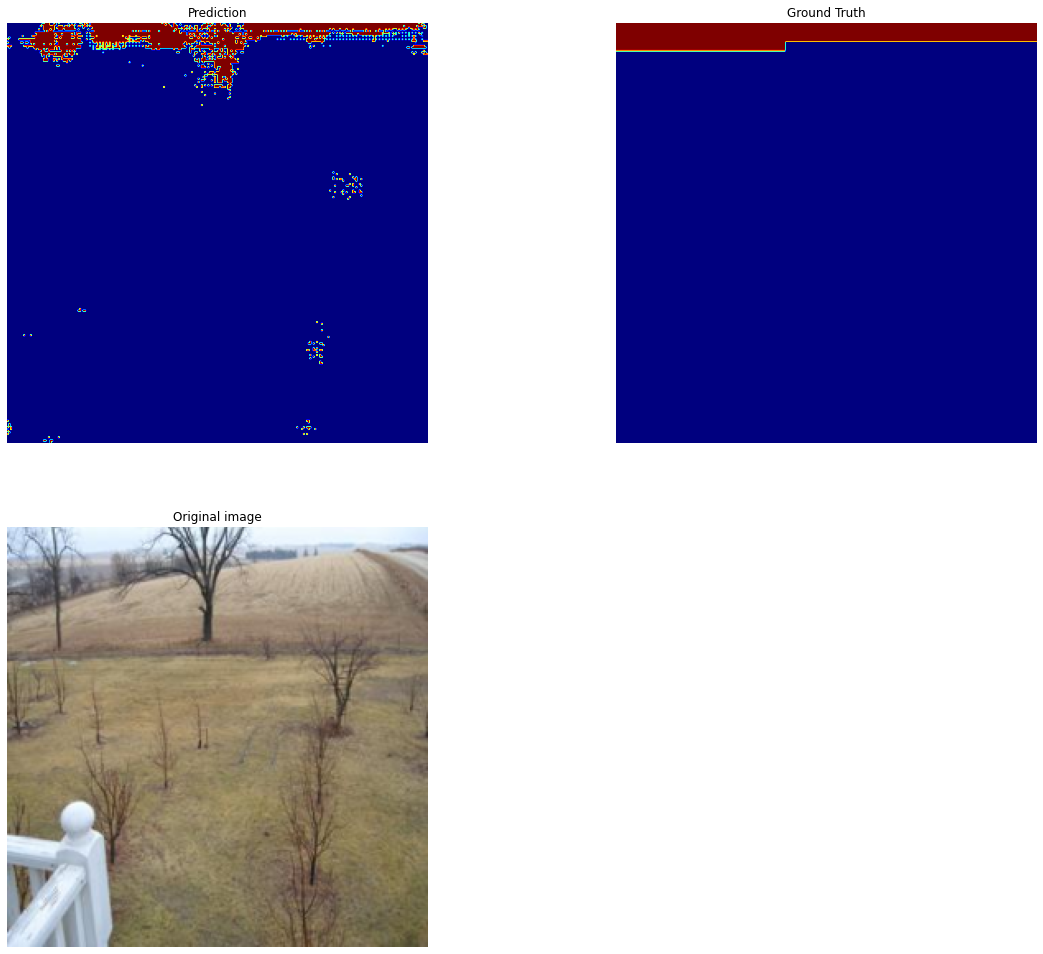

In [ ]:
img, mask = next(iter(val))
predict = seg_model.predict(numpy_images)
plt.figure(figsize=(10,4))

fig = plt.figure(figsize=(20, 17))

j = 7

fig.add_subplot(2,2,1)
i = tf.argmax(predict[j], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(numpy_labels[j][:,:,0], cmap="jet")
plt.axis("off")
plt.title("Ground Truth")

fig.add_subplot(2,2,3)
plt.imshow(numpy_images[j], cmap="jet")
plt.axis("off")
plt.title("Original image")
plt.show()

## VGG16

VGG16 (256x256x3)

In [ ]:
vgg16 = keras.applications.VGG16(input_shape=[256,256,3], 
                                      include_top=False, 
                                      weights="imagenet")

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
"""Input layer
I'm using 256x256x3 instead of the original 300x300x3 of the data, since powers of two seemed to work better for UNET-model."""
input = keras.layers.Input(shape=[256,256,3])

"""Downstack names from VGG19"""
downstack_layers = ["block1_conv1", 
             "block1_pool",                
             "block2_pool", 
             "block3_pool",  
             "block4_pool",  
             "block5_pool"
             ]

"""Upstack layers from pix2pix"""
upstack_layers = [pix2pix.upsample(1024,3),
          pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3)]#,
          #pix2pix.upsample(64,3)]

"""Get the list of skip connections outputs"""
skip_outputs = [vgg16.get_layer(x).output for x in downstack_layers]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])      

"""Initialize the downstack model"""
downstack = keras.Model(inputs=vgg16.input,
                       outputs=skip_outputs)
downstack.trainable = False     

"""Create the downstack hierarchy"""
encoder = downstack(input)
layer_out = encoder[-1]
skip_connections = reversed(encoder[:-1])

"""Map the skip connections"""
for decoder, skip in zip(upstack_layers, skip_connections):
    layer_out = decoder(layer_out)
    layer_out = keras.layers.Concatenate()([layer_out, skip])
    
"""6 classed output (1-5 weather categories + 0 as none)"""
output = keras.layers.Conv2DTranspose(6, 3,
                                  strides=2,
                                  padding="same",
                                  )(layer_out)

"""Combine the connections"""
seg_model = keras.Model(inputs=input, outputs=output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='block4_pool/MaxPool:0', description="created by layer 'block4_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [ ]:
keras.utils.plot_model(seg_model, show_shapes=True)

In [ ]:
"""seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=["accuracy"]) """

seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=["accuracy"]) 

In [ ]:
hist = seg_model.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=10)

Epoch 1/10
25/25 [==============================] - 19s 713ms/step - loss: 0.7691 - accuracy: 0.7688 - val_loss: 0.8205 - val_accuracy: 0.8508
Epoch 2/10
25/25 [==============================] - 18s 738ms/step - loss: 0.4729 - accuracy: 0.8584 - val_loss: 0.5431 - val_accuracy: 0.8639
Epoch 3/10
25/25 [==============================] - 18s 725ms/step - loss: 0.4109 - accuracy: 0.8710 - val_loss: 0.4789 - val_accuracy: 0.8648
Epoch 4/10
25/25 [==============================] - 17s 698ms/step - loss: 0.3842 - accuracy: 0.8754 - val_loss: 0.4014 - val_accuracy: 0.8801
Epoch 5/10
25/25 [==============================] - 17s 694ms/step - loss: 0.3893 - accuracy: 0.8771 - val_loss: 0.3988 - val_accuracy: 0.8749
Epoch 6/10
25/25 [==============================] - 18s 710ms/step - loss: 0.4111 - accuracy: 0.8677 - val_loss: 0.4709 - val_accuracy: 0.8592
Epoch 7/10
25/25 [==============================] - 18s 716ms/step - loss: 0.3912 - accuracy: 0.8758 - val_loss: 0.4331 - val_accuracy: 0.8671

In [ ]:
"""Save model"""
keras.models.save_model(model=seg_model, filepath=seg_model_vgg16_save_dir) 

"""Load model"""
#seg_model = keras.models.load_model(filepath=seg_model_save_dir)

for images, labels in val.take(1): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

<Figure size 720x288 with 0 Axes>

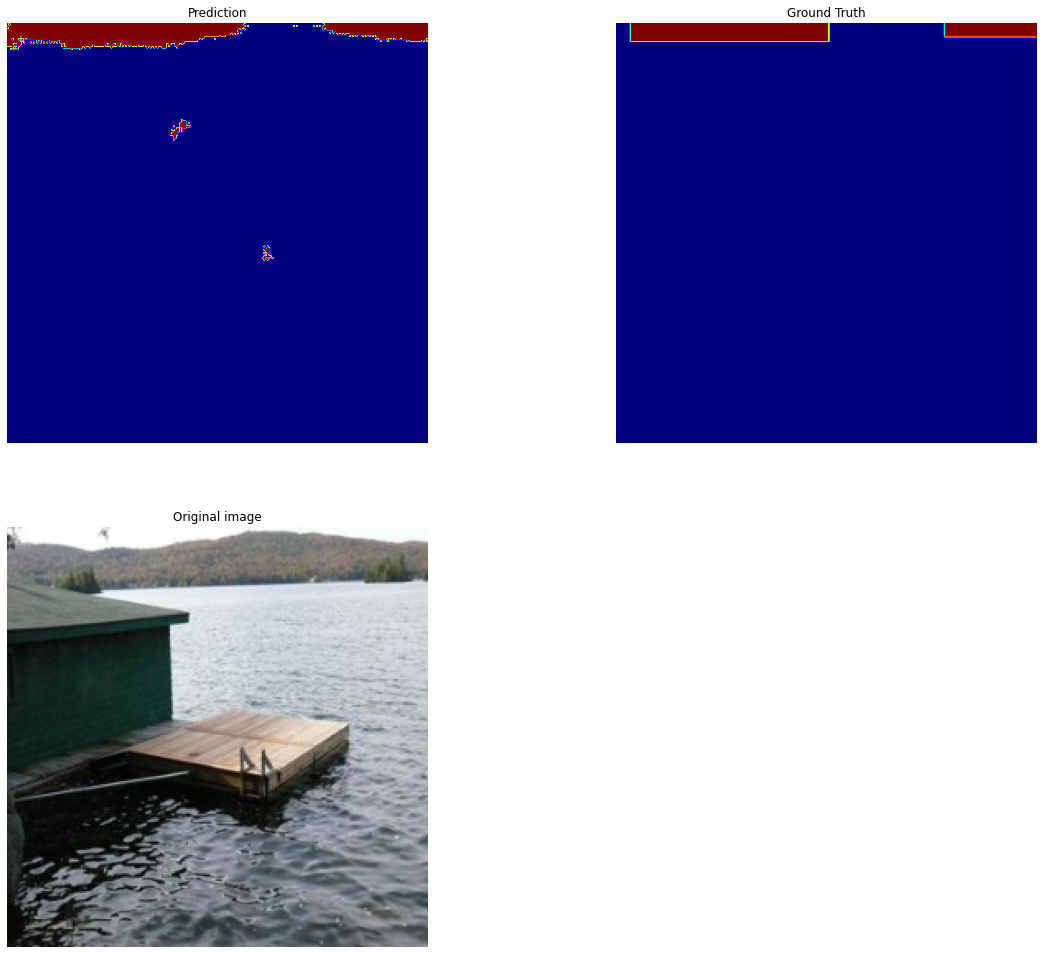

In [ ]:
img, mask = next(iter(val))
predict = seg_model.predict(numpy_images)
plt.figure(figsize=(10,4))

fig = plt.figure(figsize=(20, 17))

fig.add_subplot(2,2,1)
i = tf.argmax(predict[1], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(numpy_labels[1][:,:,0], cmap="jet")
plt.axis("off")
plt.title("Ground Truth")

fig.add_subplot(2,2,3)
plt.imshow(numpy_images[1], cmap="jet")
plt.axis("off")
plt.title("Original image")
plt.show()

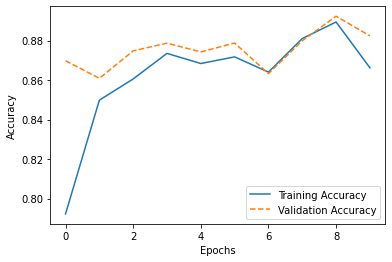

In [ ]:
history = hist.history
acc=history["accuracy"]
val_acc = history["val_accuracy"]

plt.plot(acc, "-", label="Training Accuracy")
plt.plot(val_acc, "--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##DenseNet121

In [ ]:
dense121 = keras.applications.densenet.DenseNet121(input_shape=[256,256,3], 
                                      include_top=False, 
                                      weights="imagenet")

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
keras.utils.plot_model(dense121, show_shapes=True)

In [ ]:
for layer in dense121.layers:
    print(layer.name)

In [ ]:
"""Input layer
I'm using 256x256x3 instead of the original 300x300x3 of the data, since powers of two seemed to work better for UNET-model."""
input = keras.layers.Input(shape=[256,256,3])

"""Downstack names from DenseNet"""
downstack_layers = ['conv1/relu', #64*64
             'pool2_relu', 
             'pool3_relu',  
             'pool4_relu', 
             'relu' #4*4
             ]

"""downstack_layers = ["block1_conv1", 
             "block1_pool",                
             "block2_pool", 
             "block3_pool",  
             "block4_pool",  
             "block5_pool"
             ]"""

"""Upstack layers from pix2pix"""
upstack_layers = [pix2pix.upsample(1024,3),
          pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3)]#,
          #pix2pix.upsample(64,3)]

"""Get the list of skip connections outputs"""
skip_outputs = [dense121.get_layer(x).output for x in downstack_layers]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])      

"""Initialize the downstack model"""
downstack = keras.Model(inputs=dense121.input,
                       outputs=skip_outputs)
downstack.trainable = False     

"""Create the downstack hierarchy"""
encoder = downstack(input)
layer_out = encoder[-1]
skip_connections = reversed(encoder[:-1])

"""Map the skip connections"""
for decoder, skip in zip(upstack_layers, skip_connections):
    layer_out = decoder(layer_out)
    layer_out = keras.layers.Concatenate()([layer_out, skip])
    
"""6 classed output (1-5 weather categories + 0 as none)"""
output = keras.layers.Conv2DTranspose(6, 3,
                                  strides=2,
                                  padding="same",
                                  )(layer_out)

"""Combine the connections"""
seg_model = keras.Model(inputs=input, outputs=output)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [ ]:
"""seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=["accuracy"]) """

seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=["accuracy"]) 

In [ ]:
hist = seg_model.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=10)

Epoch 1/10
25/25 [==============================] - 33s 858ms/step - loss: 0.7892 - accuracy: 0.7929 - val_loss: 1.0037 - val_accuracy: 0.8271
Epoch 2/10
25/25 [==============================] - 20s 805ms/step - loss: 0.4154 - accuracy: 0.8761 - val_loss: 0.7162 - val_accuracy: 0.8455
Epoch 3/10
25/25 [==============================] - 19s 780ms/step - loss: 0.3993 - accuracy: 0.8698 - val_loss: 0.4103 - val_accuracy: 0.8784
Epoch 4/10
25/25 [==============================] - 19s 765ms/step - loss: 0.3492 - accuracy: 0.8848 - val_loss: 0.3838 - val_accuracy: 0.8867
Epoch 5/10
25/25 [==============================] - 19s 771ms/step - loss: 0.3314 - accuracy: 0.8980 - val_loss: 0.3251 - val_accuracy: 0.9045
Epoch 6/10
25/25 [==============================] - 19s 781ms/step - loss: 0.3537 - accuracy: 0.8908 - val_loss: 0.3537 - val_accuracy: 0.8925
Epoch 7/10
25/25 [==============================] - 19s 780ms/step - loss: 0.3278 - accuracy: 0.8993 - val_loss: 0.3541 - val_accuracy: 0.8929

In [ ]:
"""Save model"""
#keras.models.save_model(model=seg_model, filepath=seg_model_dense121_save_dir)

"""Load model"""
#seg_model = keras.models.load_model(filepath=seg_model_dense121_save_dir)

for images, labels in val.take(1): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

<Figure size 720x288 with 0 Axes>

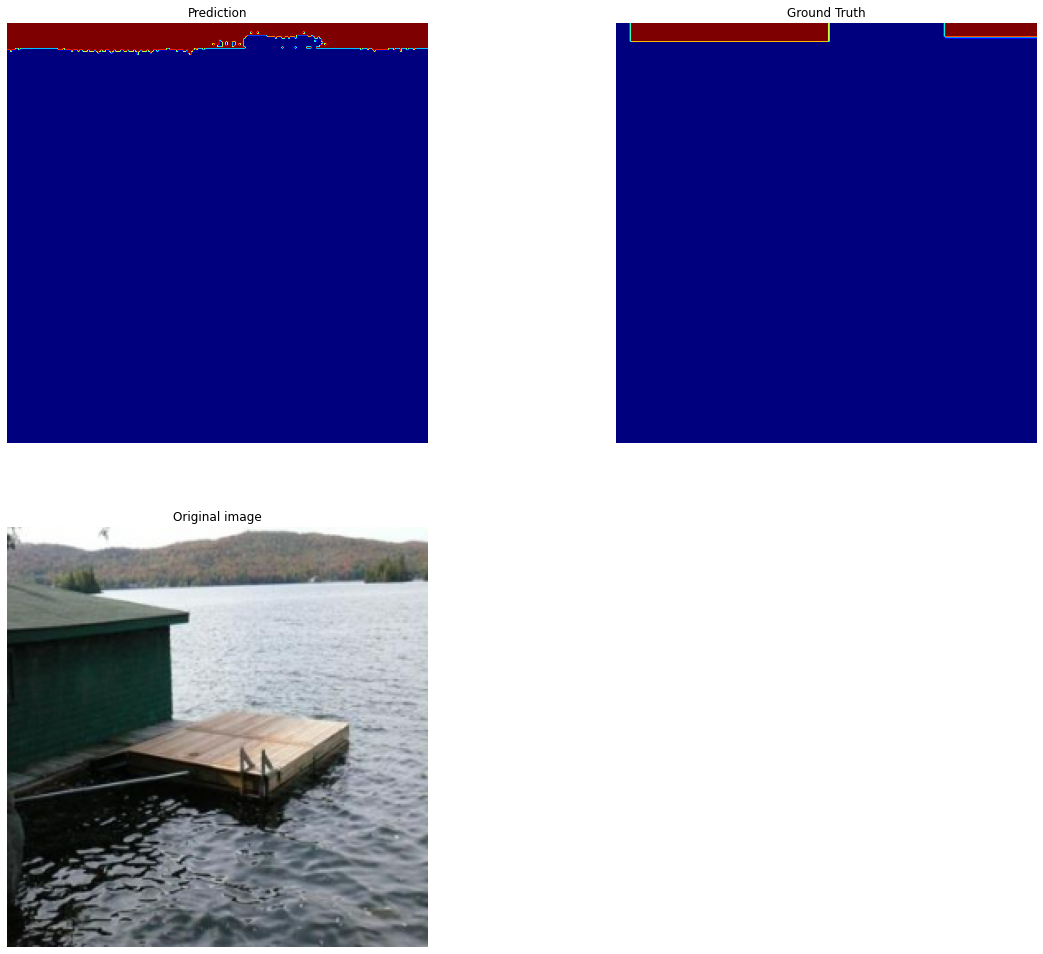

In [ ]:
img, mask = next(iter(val))
predict = seg_model.predict(numpy_images)
plt.figure(figsize=(10,4))

fig = plt.figure(figsize=(20, 17))

fig.add_subplot(2,2,1)
i = tf.argmax(predict[1], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(numpy_labels[1][:,:,0], cmap="jet")
plt.axis("off")
plt.title("Ground Truth")

fig.add_subplot(2,2,3)
plt.imshow(numpy_images[1], cmap="jet")
plt.axis("off")
plt.title("Original image")
plt.show()

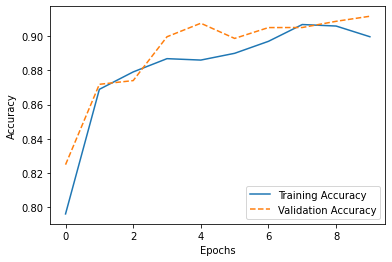

In [ ]:
history = hist.history
acc=history["accuracy"]
val_acc = history["val_accuracy"]

plt.plot(acc, "-", label="Training Accuracy")
plt.plot(val_acc, "--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##DenseNet169

In [ ]:
dense169 = keras.applications.densenet.DenseNet169(input_shape=[256,256,3], 
                                      include_top=False, 
                                      weights="imagenet")

51877672/51877672 [==============================] - 1s 0us/step


In [ ]:
keras.utils.plot_model(dense169, show_shapes=True)

In [ ]:
for layer in dense169.layers:
    print(layer.name)

In [ ]:
"""Input layer
I'm using 256x256x3 instead of the original 300x300x3 of the data, since powers of two seemed to work better for UNET-model."""
input = keras.layers.Input(shape=[256,256,3])

"""Downstack names from DenseNet"""
downstack_layers = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

"""downstack_layers = ["block1_conv1", 
             "block1_pool",                
             "block2_pool", 
             "block3_pool",  
             "block4_pool",  
             "block5_pool"
             ]"""

"""Upstack layers from pix2pix"""
upstack_layers = [pix2pix.upsample(1024,3),
          pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3)]#,
          #pix2pix.upsample(64,3)]

"""Get the list of skip connections outputs"""
skip_outputs = [dense169.get_layer(x).output for x in downstack_layers]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])      

"""Initialize the downstack model"""
downstack = keras.Model(inputs=dense169.input,
                       outputs=skip_outputs)
downstack.trainable = False     

"""Create the downstack hierarchy"""
encoder = downstack(input)
layer_out = encoder[-1]
skip_connections = reversed(encoder[:-1])

"""Map the skip connections"""
for decoder, skip in zip(upstack_layers, skip_connections):
    layer_out = decoder(layer_out)
    layer_out = keras.layers.Concatenate()([layer_out, skip])
    
"""6 classed output (1-5 weather categories + 0 as none)"""
output = keras.layers.Conv2DTranspose(6, 3,
                                  strides=2,
                                  padding="same",
                                  )(layer_out)

"""Combine the connections"""
seg_model = keras.Model(inputs=input, outputs=output)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 1280), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1664), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [ ]:
"""seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=["accuracy"])"""

seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=["accuracy"]) 

In [ ]:
hist = seg_model.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=15)

Epoch 1/15
25/25 [==============================] - 19s 751ms/step - loss: 0.2541 - accuracy: 0.9216 - val_loss: 0.2868 - val_accuracy: 0.9095
Epoch 2/15
25/25 [==============================] - 19s 747ms/step - loss: 0.2776 - accuracy: 0.9120 - val_loss: 0.3067 - val_accuracy: 0.9074
Epoch 3/15
25/25 [==============================] - 19s 755ms/step - loss: 0.2849 - accuracy: 0.9054 - val_loss: 0.2918 - val_accuracy: 0.9094
Epoch 4/15
25/25 [==============================] - 19s 759ms/step - loss: 0.2576 - accuracy: 0.9193 - val_loss: 0.3009 - val_accuracy: 0.9078
Epoch 5/15
 8/25 [========>.....................] - ETA: 11s - loss: 0.2496 - accuracy: 0.9189

KeyboardInterrupt: ignored

In [ ]:
"""Save model"""
#keras.models.save_model(model=seg_model, filepath=seg_model_dense169_save_dir) 

"""Load model"""
#seg_model = keras.models.load_model(filepath=seg_model_dense121_save_dir)

for images, labels in val.take(1): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

1/1 [==============================] - 2s 2s/step


<Figure size 720x288 with 0 Axes>

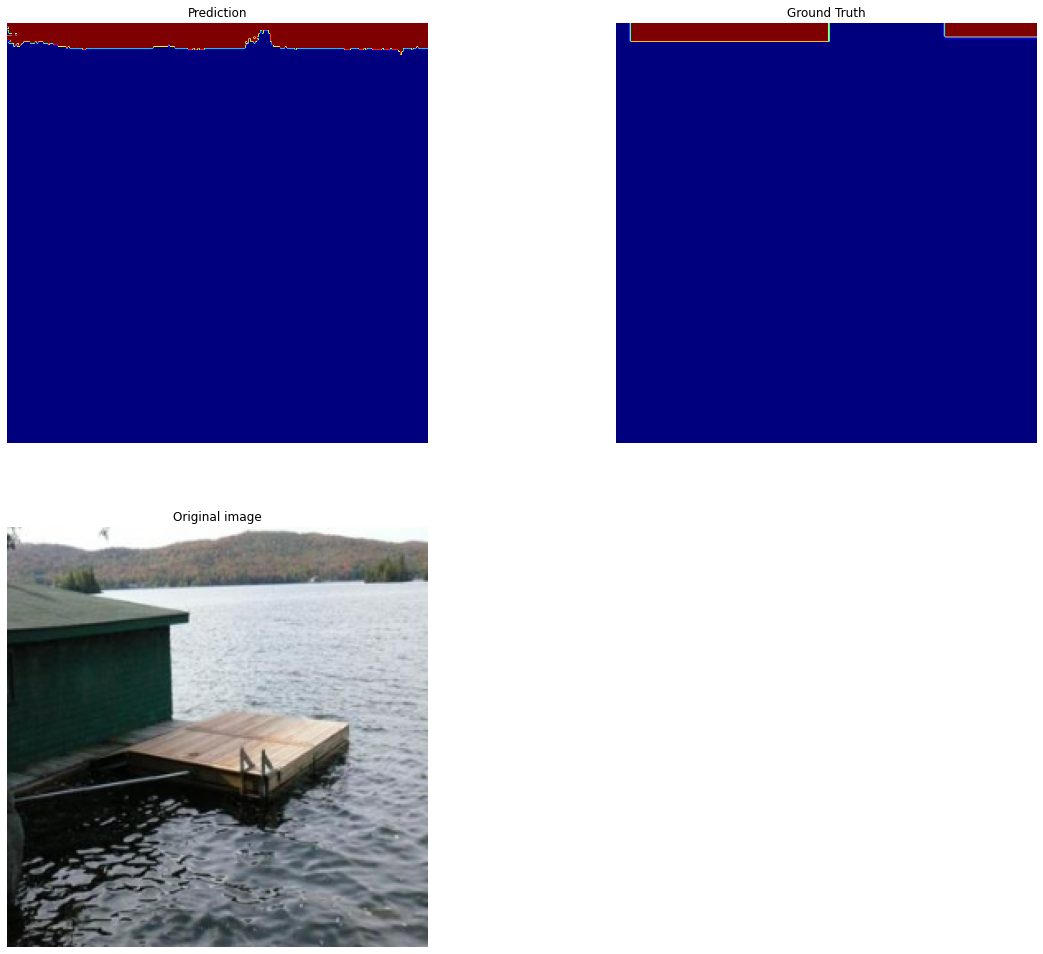

In [ ]:
img, mask = next(iter(val))
predict = seg_model.predict(numpy_images)
plt.figure(figsize=(10,4))

fig = plt.figure(figsize=(20, 17))

fig.add_subplot(2,2,1)
i = tf.argmax(predict[1], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(numpy_labels[1][:,:,0], cmap="jet")
plt.axis("off")
plt.title("Ground Truth")

fig.add_subplot(2,2,3)
plt.imshow(numpy_images[1], cmap="jet")
plt.axis("off")
plt.title("Original image")
plt.show()

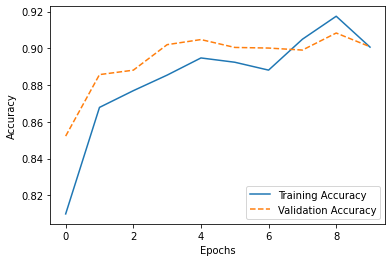

In [ ]:
history = hist.history
acc=history["accuracy"]
val_acc = history["val_accuracy"]

plt.plot(acc, "-", label="Training Accuracy")
plt.plot(val_acc, "--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##DenseNet201

In [ ]:
dense201 = keras.applications.densenet.DenseNet201(input_shape=[256,256,3], 
                                      include_top=False, 
                                      weights="imagenet")

In [ ]:
keras.utils.plot_model(dense201, show_shapes=True)

In [ ]:
"""Input layer
I'm using 256x256x3 instead of the original 300x300x3 of the data, since powers of two seemed to work better for UNET-model."""
input = keras.layers.Input(shape=[256,256,3])

"""Downstack names from DenseNet"""
downstack_layers = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

"""Upstack layers from pix2pix"""
upstack_layers = [pix2pix.upsample(1024,3),
          pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3)]#,
          #pix2pix.upsample(64,3)]

"""Get the list of skip connections outputs"""
skip_outputs = [dense201.get_layer(x).output for x in downstack_layers]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])      

"""Initialize the downstack model"""
downstack = keras.Model(inputs=dense201.input,
                       outputs=skip_outputs)
downstack.trainable = False     

"""Create the downstack hierarchy"""
encoder = downstack(input)
layer_out = encoder[-1]
skip_connections = reversed(encoder[:-1])

"""Map the skip connections"""
for decoder, skip in zip(upstack_layers, skip_connections):
    layer_out = decoder(layer_out)
    layer_out = keras.layers.Concatenate()([layer_out, skip])
    
"""6 classed output (1-5 weather categories + 0 as none)"""
output = keras.layers.Conv2DTranspose(6, 3,
                                  strides=2,
                                  padding="same",
                                  )(layer_out)

"""Combine the connections"""
seg_model = keras.Model(inputs=input, outputs=output)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 1792), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1920), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


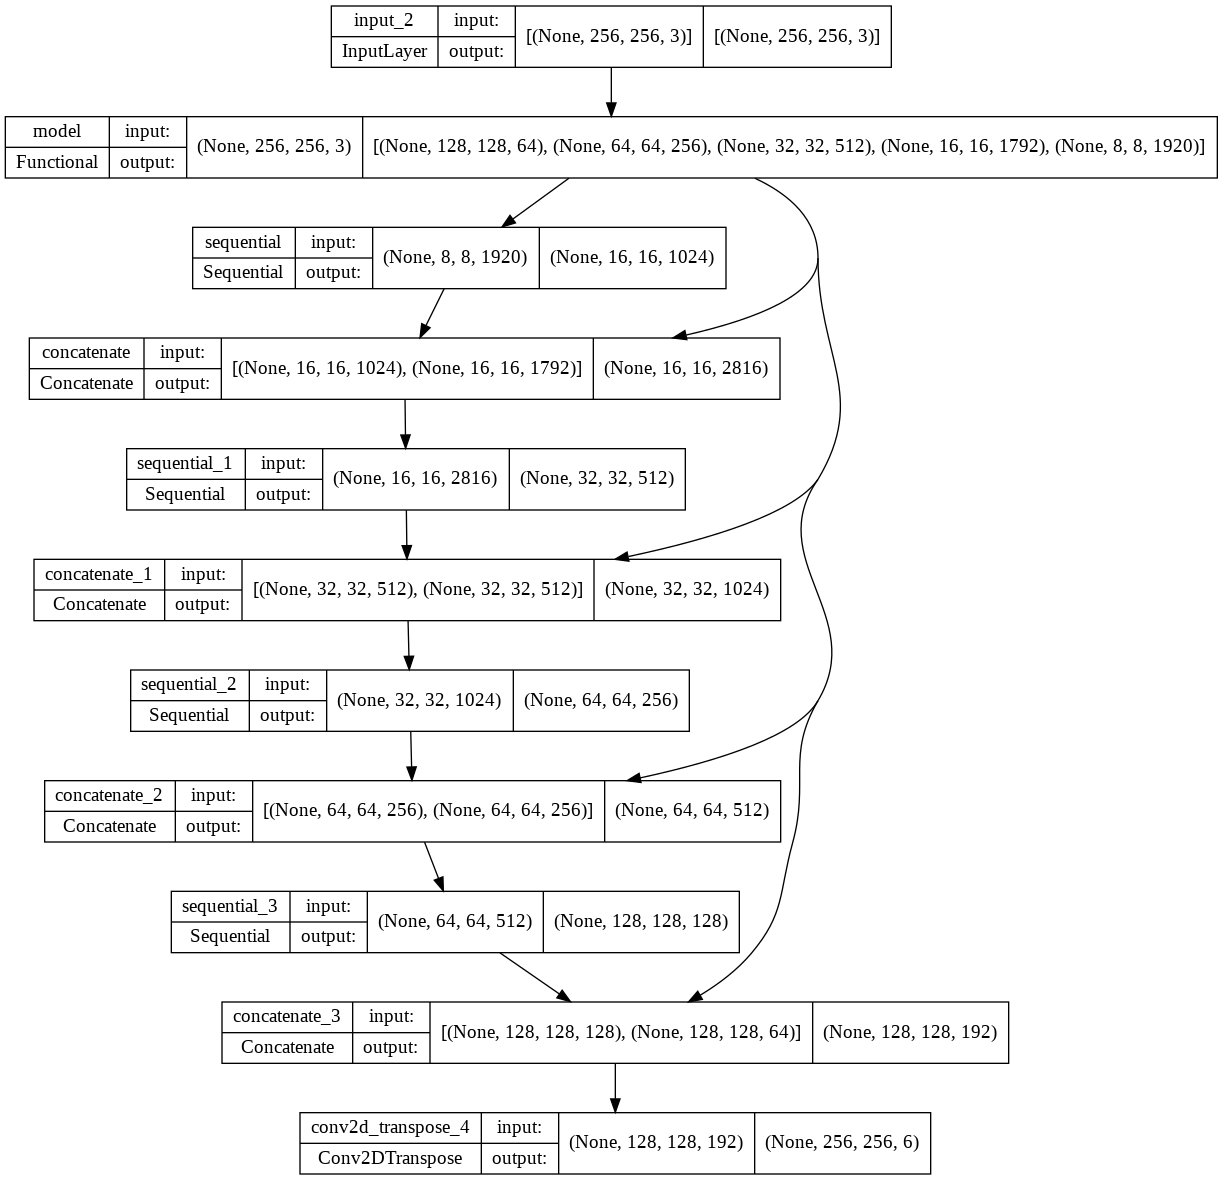

In [ ]:
"""for layer in dense201.layers:
    print(layer.name)"""

keras.utils.plot_model(seg_model, show_shapes=True)

In [ ]:
seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=["accuracy"])

"""seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=["accuracy"]) """

'seg_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\n            metrics=["accuracy"]) '

In [ ]:
hist = seg_model.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=10)

Epoch 1/10
25/25 [==============================] - 65s 988ms/step - loss: 0.7257 - accuracy: 0.7641 - val_loss: 0.7136 - val_accuracy: 0.7307
Epoch 2/10
25/25 [==============================] - 21s 851ms/step - loss: 0.4920 - accuracy: 0.8316 - val_loss: 0.5877 - val_accuracy: 0.8321
Epoch 3/10
25/25 [==============================] - 21s 857ms/step - loss: 0.4627 - accuracy: 0.8366 - val_loss: 0.5596 - val_accuracy: 0.8325
Epoch 4/10
25/25 [==============================] - 22s 871ms/step - loss: 0.4341 - accuracy: 0.8484 - val_loss: 0.4622 - val_accuracy: 0.8442
Epoch 5/10
25/25 [==============================] - 22s 885ms/step - loss: 0.4300 - accuracy: 0.8473 - val_loss: 0.4457 - val_accuracy: 0.8481
Epoch 6/10
25/25 [==============================] - 23s 905ms/step - loss: 0.4421 - accuracy: 0.8440 - val_loss: 0.4444 - val_accuracy: 0.8439
Epoch 7/10
25/25 [==============================] - 23s 910ms/step - loss: 0.4494 - accuracy: 0.8390 - val_loss: 0.4383 - val_accuracy: 0.8430

In [ ]:
seg_model_dense201_v2_save_dir = "/content/drive/MyDrive/Diplomityo/Models/seg_model_dense201_sunny_and_cloudy"

"""Save model"""
#keras.models.save_model(model=seg_model, filepath=seg_model_dense201_v2_save_dir) 

"""Load model"""
#seg_model = keras.models.load_model(filepath=seg_model_dense201_save_dir)

"""for images, labels in val.take(1): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()"""

'for images, labels in val.take(1): # take elements from the dataset\n    numpy_images = images.numpy()\n    numpy_labels = labels.numpy()'

<Figure size 720x288 with 0 Axes>

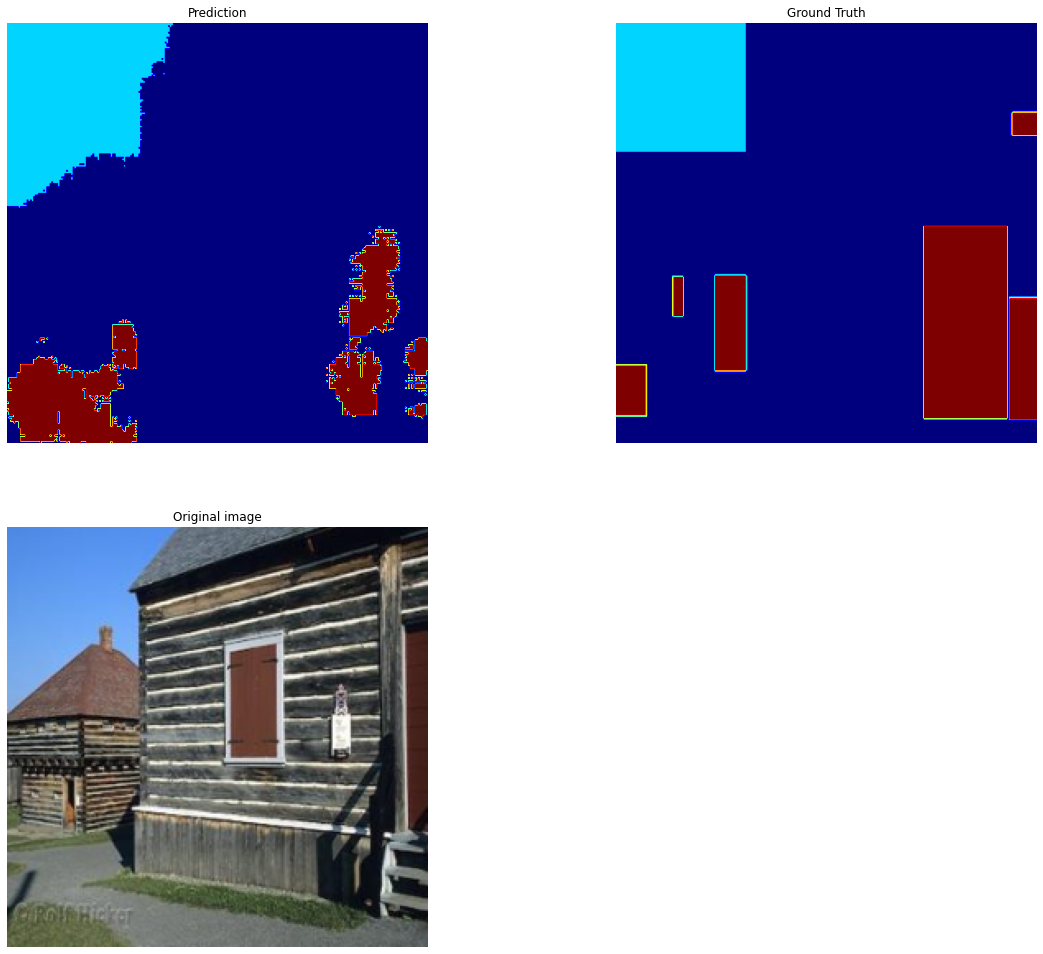

In [ ]:
"""for images, labels in val.take(1): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()"""

#img, mask = next(iter(val))
#predict = seg_model.predict(numpy_images)
plt.figure(figsize=(10,4))

fig = plt.figure(figsize=(20, 17))

j = 3

fig.add_subplot(2,2,1)
i = tf.argmax(predict[j], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(numpy_labels[j][:,:,0], cmap="jet")
plt.axis("off")
plt.title("Ground Truth")

fig.add_subplot(2,2,3)
plt.imshow(numpy_images[j], cmap="jet")
plt.axis("off")
plt.title("Original image")
plt.show()

In [ ]:
history = hist.history
acc=history["accuracy"]
val_acc = history["val_accuracy"]

plt.plot(acc, "-", label="Training Accuracy")
plt.plot(val_acc, "--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Segmentation model evaluation

In [ ]:
"""Load model (uncomment if no model is loaded)"""
#seg_model = keras.models.load_model(filepath=seg_model_dense201_save_dir)

for images, labels in val.take(1): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

###Test

<Figure size 720x288 with 0 Axes>

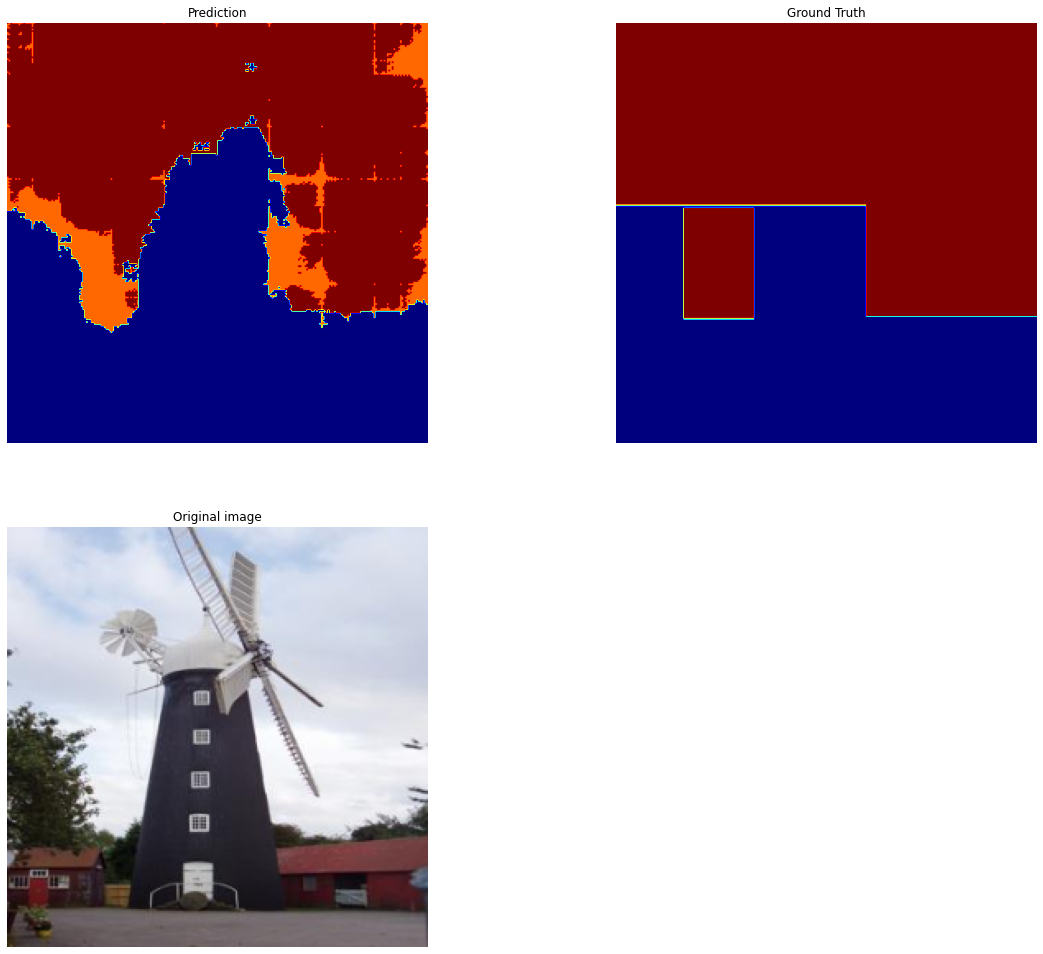

In [ ]:
#img, mask = next(iter(val))
predict = seg_model.predict(numpy_images)
labels = numpy_labels[5][:,:,0]
plt.figure(figsize=(10,4))

fig = plt.figure(figsize=(20, 17))

fig.add_subplot(2,2,1)
i = tf.argmax(predict[5], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(labels, cmap="jet")
plt.axis("off")
plt.title("Ground Truth")

fig.add_subplot(2,2,3)
plt.imshow(numpy_images[5], cmap="jet")
plt.axis("off")
plt.title("Original image")
plt.show()

In [ ]:
asd = np.argmax(predict[5], axis=-1)
print(asd)
print(labels)

intersection = np.logical_and(labels, asd)
union = np.logical_or(labels, asd)
iou_score = np.sum(intersection) / np.sum(union)

print(iou_score)

[[5 4 5 ... 4 4 4]
 [4 4 5 ... 4 4 4]
 [4 5 5 ... 4 4 4]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.8774628193720605


# Attention model

## Take segmentation output

In [ ]:
"""Load model"""
seg_model = keras.models.load_model(filepath=seg_model_dense201_save_dir)

In [ ]:
keras.utils.plot_model(seg_model, show_shapes=True)

In [ ]:
att_model = keras.Model(seg_model.input, seg_model.get_layer(index = 9).output)

Seguential layers don't work, but concatenate ones do!

In [ ]:
layer_names=[layer.name for layer in att_model.layers]
#layer_names=[layer.name for layer in seg_model.layers]
print(layer_names)

att_model_activations = [7, 10, 16, 17, 18, 20, 32, 34, 38, 42, 48, 69, 72, 73, 76, 83, 93, 95, 103, 113, 124, 125, 127]

['input_2', 'model', 'sequential', 'concatenate', 'sequential_1', 'concatenate_1', 'sequential_2', 'concatenate_2', 'sequential_3', 'concatenate_3']


In [ ]:
for images, labels in val.take(3): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

#number for testing image
num = 18

att_input = numpy_images[num].reshape(-1, 256, 256, 3)

"""Reshape a single image to 4d"""
#activation_conf = att_model.predict(att_input) 

activation_test = np.array(activation_conf)
type(activation_test)

#predict = seg_model.predict(numpy_images)

fig = plt.figure(figsize=(20, 17))

fig.add_subplot(2,2,1)
i = tf.argmax(predict[num], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(numpy_labels[num][:,:,0], cmap="jet")
plt.axis("off")
plt.title("Ground Truth")

fig.add_subplot(2,2,3)
#plt.imshow(activations[0, :, :, 0-192])#, cmap='viridis') 
plt.imshow(np.argmax(activation_test[0, :, :], axis=-1))
#plt.imshow(np.argmax(activation_test[0, :, :, 7]))
plt.axis("off")
plt.title("Attention map")

fig.add_subplot(2,2,4)
plt.imshow(numpy_images[num], cmap="jet")
plt.axis("off")
plt.title("Original image")
plt.show()

In [ ]:
for images, labels in val.take(3): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [ ]:
from keras import backend as K

def get_class_activation_map(model, img):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    
    # expand dimension to fit the image to a network accepted input size
    img = np.expand_dims(img, axis=0)

    # predict to get the winning class
    #predictions = model.predict(img)
    #label_index = np.argmax(predictions)
    label_index = 1

    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    class_weights_winner = np.argmax(class_weights_winner[0, :, :], axis = 0)

    """plt.imshow(att_all.reshape(128, 128, 1)[:,:,0], cmap='gray')
    plt.axis("off")
    plt.title("Ground Truth")
    plt.show()"""

    # get the final conv layer
    final_conv_layer = model.get_layer("concatenate_3")
    
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)
    print(conv_outputs.shape)
    
    # bilinear upsampling to resize each filtered image to size of original image 
    #mat_for_mult = scipy.ndimage.zoom(conv_outputs, (1, 1, 1), order=1) # dim: 224 x 224 x 2048

    #print(mat_for_mult.shape)

    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(conv_outputs, class_weights_winner) # dim: 224 x 224
    
    # return class activation map
    return final_output, label_index

a, b = get_class_activation_map(seg_model, numpy_images[1])

In [ ]:

fig = plt.figure(figsize=(10, 10))

predict = seg_model.predict(numpy_images)
predict = np.argmax(predict[1], axis=-1)

fig.add_subplot(1,3,1)
plt.imshow(a.reshape(128, 128, 1)[:,:,0], cmap='gray')
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(1,3,2)
plt.imshow(numpy_images[1], cmap='jet')
plt.axis("off")
plt.title("Ground Truth")
plt.show()

fig.add_subplot(1,3,3)
plt.imshow(predict, cmap='jet')
plt.axis("off")
plt.title("Ground Truth")
plt.show()

(23, 128, 128)


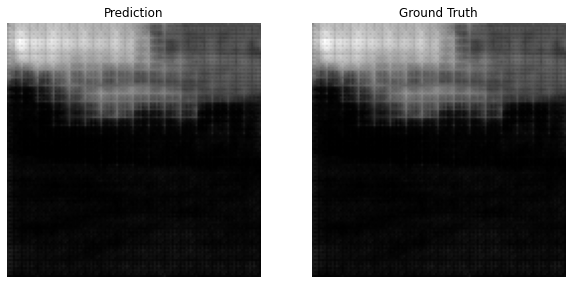

[[1.5293818  1.9297959  1.9947379  ... 0.947681   0.98477125 1.0349605 ]
 [1.6796149  1.7218659  1.9267257  ... 0.85538656 0.8147394  0.8254443 ]
 [1.8910849  2.088613   1.9129236  ... 0.94756174 0.94064265 0.82831025]
 ...
 [0.25088271 0.1425321  0.13327293 ... 0.14332202 0.17081097 0.04960092]
 [0.21078257 0.21386206 0.16898178 ... 0.18754958 0.06600725 0.06672988]
 [0.10445725 0.03516915 0.05481255 ... 0.07026771 0.07319678 0.1278467 ]]


'plt.imshow(att_clumsy_test[:,:,0], cmap=\'gray\')\nfig = plt.figure(figsize=(20, 17))\n\nfig.add_subplot(2,2,1)\ni = tf.argmax(predict[num], axis=-1)\nplt.imshow(i,cmap="jet")\nplt.axis("off")\nplt.title("Prediction")\n\nfig.add_subplot(2,2,2)\nplt.imshow(numpy_labels[num][:,:,0], cmap="jet")\nplt.axis("off")\nplt.title("Ground Truth")\nplt.show()'

In [ ]:
def attention_clumsy(att_model_activations, activation_test):
  att = []
  for i in att_model_activations:
    att.append(activation_test[0, :, :, i])
  att = np.array(att)

  print(att.shape)
  a = np.sum(att, axis=0)

  #att_all = ((a-np.min(a))/(np.max(a)-np.min(a))).reshape(128, 128, 1)
  att_all = np.mean(att, axis=0)

  fig = plt.figure(figsize=(10, 10))

  fig.add_subplot(1,2,1)
  plt.imshow(a.reshape(128, 128, 1)[:,:,0], cmap='gray')
  plt.axis("off")
  plt.title("Prediction")

  fig.add_subplot(1,2,2)
  plt.imshow(att_all.reshape(128, 128, 1)[:,:,0], cmap='gray')
  plt.axis("off")
  plt.title("Ground Truth")
  plt.show()

  #print(a)
  print(att_all)

  return a.reshape(128, 128, 1)#tt_all

att_model_activations = [7, 10, 16, 17, 18, 20, 32, 34, 38, 42, 48, 69, 72, 73, 76, 83, 93, 95, 103, 113, 124, 125, 127]

#print(activation_test.shape)
att_clumsy_test = attention_clumsy(att_model_activations, activation_test)

"""plt.imshow(att_clumsy_test[:,:,0], cmap='gray')
fig = plt.figure(figsize=(20, 17))

fig.add_subplot(2,2,1)
i = tf.argmax(predict[num], axis=-1)
plt.imshow(i,cmap="jet")
plt.axis("off")
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(numpy_labels[num][:,:,0], cmap="jet")
plt.axis("off")
plt.title("Ground Truth")
plt.show()"""

In [ ]:
"""Reshape a single image to 4d"""
activation_test = np.repeat(activation_conf[0], 2, axis=0)
activation_test = np.repeat(activation_test, 2, axis=1)

type(activation_test)
activations = np.array(activation_test)
print(activation_test.shape)

plt.subplot(1,2,1)
plt.imshow(activation_test[:, :, 127])
plt.title("Original Map")
plt.subplot(1,2,2)
plt.imshow(activation_test[:, :, 127])
plt.title("Resized Map")

att_model_activations = [7, 10, 16, 17, 18, 20, 32, 34, 38, 42, 48, 69, 72, 73, 76, 83, 93, 95, 103, 113, 124, 125, 127]
for i in att_model_activations:
  print(activation_test[:, :, i])
  #print(np.argmax(activation_test[:, :, i]))

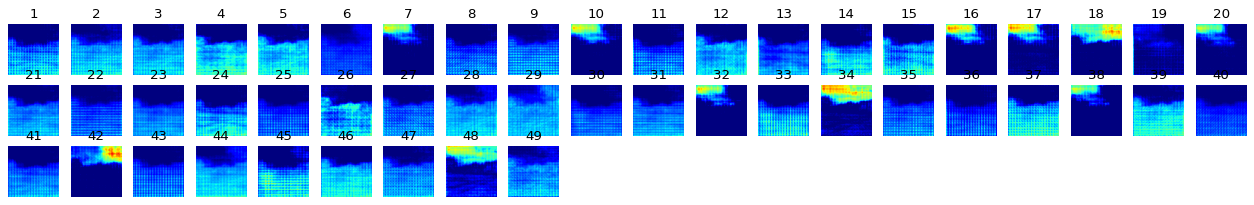

In [ ]:
plt.figure(figsize=(20,20), dpi=80)
for i in range(0, 50):
    if (i > 0):
      plt.subplot(20,20,i)
    img = activations[:,:,i]
    plt.imshow(img, cmap="jet")
    plt.title(i)
    plt.axis("off")
plt.show()

In [ ]:
"""Save model"""
#keras.models.save_model(model=att_model, filepath=att_model_save_dir) 

"""Load model"""
att_model = keras.models.load_model(filepath=att_model_save_dir)

# Combine models and visualize an example

input x = original image

seg + attention to find the areas of weather 

initial generator to change the entire image

finally combine all, i.e. only get the intersection of (seg + attention) * initital generator in the final output

In [ ]:
#Load saved models from drive
generator_g = keras.models.load_model(filepath=gen_sunny_to_cloudy_model_save_dir)
#generator_f = keras.models.load_model(filepath=gen_cloudy_to_sunny_model_save_dir)
#seg_model = keras.models.load_model(filepath=seg_model_dense201_save_dir)
#seg_model = keras.models.load_model(filepath=seg_model_vgg19_save_dir)
#att_model = keras.models.load_model(filepath=att_model_save_dir)

att_model_activations = [7, 10, 16, 17, 18, 20, 32, 34, 38, 48, 69, 72, 73, 76, 83, 93, 95, 103, 113, 124, 125, 127]

(8, 256, 256, 3)
(256, 256, 3)
8
(256, 256, 3)
1/1 [==============================] - 0s 359ms/step
(1, 256, 256, 3)
(1, 256, 256, 3)
(256, 256, 3)
1/1 [==============================] - 0s 346ms/step
(1, 256, 256, 3)
(1, 256, 256, 3)
(256, 256, 3)
1/1 [==============================] - 0s 342ms/step
(1, 256, 256, 3)
(1, 256, 256, 3)
(256, 256, 3)
1/1 [==============================] - 0s 358ms/step
(1, 256, 256, 3)
(1, 256, 256, 3)
(256, 256, 3)
1/1 [==============================] - 0s 333ms/step
(1, 256, 256, 3)
(1, 256, 256, 3)
(256, 256, 3)
1/1 [==============================] - 0s 358ms/step
(1, 256, 256, 3)
(1, 256, 256, 3)
(256, 256, 3)
1/1 [==============================] - 0s 348ms/step
(1, 256, 256, 3)
(1, 256, 256, 3)
(256, 256, 3)
1/1 [==============================] - 0s 359ms/step
(1, 256, 256, 3)
(1, 256, 256, 3)


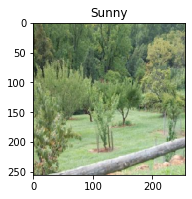

In [ ]:
test_sunny = next(iter(val_sunny))

"""gen_prediction = generator_g(test_sunny)
seg_prediction = seg_model.predict(test_sunny)
att_prediction = att_model.predict(test_sunny)"""

"""for images, labels in val.take(2): # take elements from the dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()"""

#test_sunny = next(iter(val_cloudy))
plt.subplot(121)
plt.title("Sunny")
plt.imshow(test_sunny[0] * 0.5 + 0.5)

print(test_sunny.shape)

print(test_sunny[0].shape)

np_test_sunny = test_sunny.numpy()

print(len(test_sunny))

#seg_prediction = seg_model.predict(np_test_sunny[0].reshape(-1, 256, 256, 3))
#gen_prediction = generator_g(np_test_sunny)

def combine_models(gen_model, seg_model, data): #att_model add
  processed_images = []
  
  """for images, labels in data.take(1): # take elements from the dataset
      numpy_images = images.numpy()
      #numpy_labels = labels.numpy()"""

  #numpy_images = next(iter(val_sunny))    

  for i in range(0, len(test_sunny)):
    combine_image = data[i].numpy()

    print(combine_image.shape)

    #Models want 4d images in, which is why i reshape and then take element [0]
    gen_prediction = gen_model(combine_image.reshape(-1, 256, 256, 3))
    seg_prediction = seg_model.predict(combine_image.reshape(-1, 256, 256, 3))
    #att_prediction = att_model.predict(combine_test)

    print(gen_prediction.shape)
    print(seg_prediction.shape)
    """print(att_prediction.shape)
    
    #Increase activation map size to 256x256 from 128x128
    activations = np.repeat(att_prediction, 2, axis=0)
    activations = np.repeat(activations, 2, axis=1)"""

    #Operations to normalize the images
    s1 = seg_prediction
    s2 = np.argmax(s1, axis=-1)
    s3 = s2.reshape(256, 256, 1)
    s4 = (s3-np.min(s3))/(np.max(s3)-np.min(s3))

    att = np.max(seg_prediction, axis=-1)
    #a = activations[:,:,83] + activations[:,:,95] + activations[:,:,72] + activations[:,:,73] + activations[:,:,76]
    att_all = ((att-np.min(att))/(np.max(att)-np.min(att))).reshape(256, 256, 1)
    #a1 = activations[:,:,83].reshape(256, 256, 1)

    #print(a.shape)
    #print(a1.shape)

    t1 = s3 * att_all
    t2 = (t1-np.min(t1))/(np.max(t1)-np.min(t1))
    g1 = gen_prediction
    x1 = combine_image

    #combine_seg_only = tf.multiply(s4, g1) + tf.multiply((1-s4), tf.cast(x1, tf.float32))
    combine_seg_only = tf.multiply(t2, g1) + tf.multiply((1-t2), tf.cast(x1, tf.float32))
    processed_images.append(combine_seg_only)

  processed_images = np.array(processed_images)
  return processed_images

test_combining = combine_models(generator_g, seg_model, test_sunny)

In [ ]:
print(test_combining.shape)

k = 5

fig = plt.figure(figsize=(20, 17))

test_combining = test_combining.reshape(-1, 256, 256, 3)

fig.add_subplot(1,2,1)
plt.title("Cloudy")
plt.imshow(test_combining[k] * 0.5 + 0.5)

fig.add_subplot(1,2,2)
plt.title("Sunny")
plt.imshow(np_test_sunny[k] * 0.5 + 0.5)
plt.show()

### Old tests

In [ ]:
k = 14

combine_test = numpy_images[k].reshape(-1, 256, 256, 3)

#Models want 4d images in, which is why i reshape and then take element [0]
gen_prediction = generator_g(combine_test)[0]
seg_prediction = seg_model.predict(combine_test)[0]
att_prediction = att_model.predict(combine_test)[0]

print(gen_prediction.shape)
print(seg_prediction.shape)
print(att_prediction.shape)

#Increase activation map size to 256x256 from 128x128
activations = np.repeat(att_prediction, 2, axis=0)
activations = np.repeat(activations, 2, axis=1)

#Operations to normalize the images
s1 = seg_prediction
s2 = np.argmax(s1, axis=-1)
s3 = s2.reshape(256, 256, 1)
s4 = (s3-np.min(s3))/(np.max(s3)-np.min(s3))
a = activations[:,:,83] + activations[:,:,95] + activations[:,:,72] + activations[:,:,73] + activations[:,:,76]
att_all = ((a-np.min(a))/(np.max(a)-np.min(a))).reshape(256, 256, 1)
a1 = activations[:,:,83].reshape(256, 256, 1)

print(a.shape)
print(a1.shape)

t1 = s3 * att_all
t2 = (t1-np.min(t1))/(np.max(t1)-np.min(t1))
g1 = gen_prediction
x1 = combine_test[0]

combine = tf.multiply(t2, g1) + tf.multiply((1-t2), tf.cast(x1, tf.float32))
combine_seg_only = tf.multiply(s4, g1) + tf.multiply((1-s4), tf.cast(x1, tf.float32))

(256, 256, 3)
(256, 256, 6)
(128, 128, 192)
(256, 256)
(256, 256, 1)


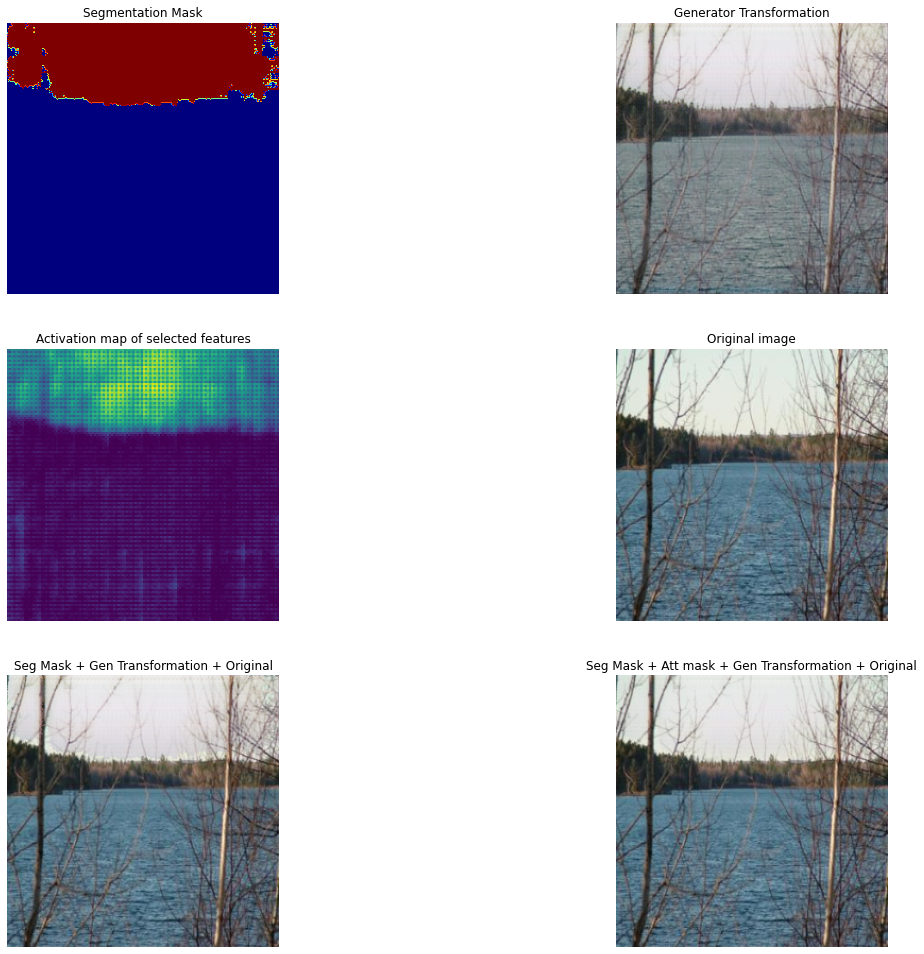

In [ ]:
fig = plt.figure(figsize=(20, 17))

fig.add_subplot(3,2,1)
plt.imshow(s2, cmap="jet")
plt.axis("off")
plt.title("Segmentation Mask")

fig.add_subplot(3,2,2)
plt.imshow(g1, cmap="jet")
plt.axis("off")
plt.title("Generator Transformation")

fig.add_subplot(3,2,3)
plt.imshow(a1)
plt.axis("off")
plt.title("Activation map of selected features")

fig.add_subplot(3,2,4)
plt.imshow(x1, cmap="jet") # * 0.5 + 0.5
plt.axis("off")
plt.title("Original image")

fig.add_subplot(3,2,5)
plt.imshow(combine_seg_only, cmap="jet") # * 0.5 + 0.5
plt.axis("off")
plt.title("Seg Mask + Gen Transformation + Original")

fig.add_subplot(3,2,6)
plt.imshow(combine, cmap="jet") # * 0.5 + 0.5 
plt.axis("off")
plt.title("Seg Mask + Att mask + Gen Transformation + Original")
plt.show()

# Evaluation

In [ ]:
from keras.applications.inception_v3 import preprocess_input

inception_model = keras.applications.inception_v3.InceptionV3(
    include_top=False, 
    pooling='avg', 
  	input_shape=(256, 256, 3)
  )

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
def calculate_fid_score(model, real_data, fake_data):
	act1 = model.predict(real_data)
	act2 = model.predict(fake_data)

	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

	ssdiff = np.sum((mu1 - mu2)**2.0)

	covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))

	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

fid_score_cyclegan_with_segmentation = calculate_fid_score(inception_model, np_test_sunny, test_combining.reshape(-1, 256, 256, 3))

cyclegan_fakes = generator_g(np_test_sunny)

fid_score_cyclegan = calculate_fid_score(inception_model, np_test_sunny, cyclegan_fakes)

print(fid_score_cyclegan_with_segmentation)
print(fid_score_cyclegan)

1/1 [==============================] - 1s 785ms/step
24.251978294712504
52.049135195710136


In [ ]:
print(test_combining.shape)

k = 6

fig = plt.figure(figsize=(20, 17))

test_combining = test_combining.reshape(-1, 256, 256, 3)

fig.add_subplot(1,3,1)
plt.title("Cloudy Thesis Model")
plt.imshow(test_combining[k] * 0.5 + 0.5)

fig.add_subplot(1,3,2)
plt.title("Cloudy Base Model")
plt.imshow(cyclegan_fakes[k] * 0.5 + 0.5)

fig.add_subplot(1,3,3)
plt.title("Sunny")
plt.imshow(np_test_sunny[k] * 0.5 + 0.5)
plt.show()